In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cdsapi
import glob
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import regionmask 

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

In [3]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918") 
outline_buffered  = gpd.read_file(f"{gis_folder}\\hudson_basin_buffered.gpkg",crs="EPSG:26918")

# fixing crs
for layer in [outline,outline_buffered]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# Prepare data
limit to 2010-2015 due to storage constraints

## P
ERA 5 obtained form ESMValTool - Forcings for the HBVmountain hydrological model: *with thanks to Rolf Hut*

In [4]:
ds_era5 = xr.load_dataset(f"{data_folder}\\ERA5_Group18_2010_2015.nc")

In [5]:
mask = regionmask.mask_geopandas(outline_buffered, 
                                 ds_era5['pr'].lon.to_numpy(), 
                                 ds_era5['pr'].lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")

In [6]:
cropped_ds_era5 = ds_era5.where(mask==0)

Pr in "kg m-2 s-1" -> *86400 mm/d

In [7]:
pr_series = cropped_ds_era5["pr"].mean(dim=["lat","lon"]).to_pandas() * 86400 
df_era5_P = pd.DataFrame(pr_series,columns=["pr"]).rename(columns={"pr":"era5"})

IMERGE from [google earth engine](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06) with thanks to clear explanations by the [intro guide.](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)

In [8]:
IMERG = pd.read_parquet(f"{data_folder}\\P\\IMERG.parquet").rename(columns={"P":"IMERG"})

Load precipitation data from stations

In [9]:
files = glob.glob(f"{data_folder}\\combined*.parquet")
df_all_data = pd.read_parquet(files[0]).loc["2010":"2015"]
station_data = df_all_data[["P"]].rename(columns={"P":"station"})

Resample to monthly

In [10]:
monlthy_p = [df_era5_P.resample("m").sum(), IMERG.resample("m").sum(), station_data.resample("m").sum()]
df_p = pd.concat(monlthy_p,axis = 1).loc["2010-03":"2014"]
df_p.head(4)

,era5,IMERG,station
2010-03-31,124.605036,290.537637,117.268370
2010-04-30,75.173069,103.298254,44.012388
2010-05-31,58.486961,130.945311,63.706235
2010-06-30,141.764704,269.680657,152.629393


Comparison:

good to see that era5 and station data overlap so closely :)

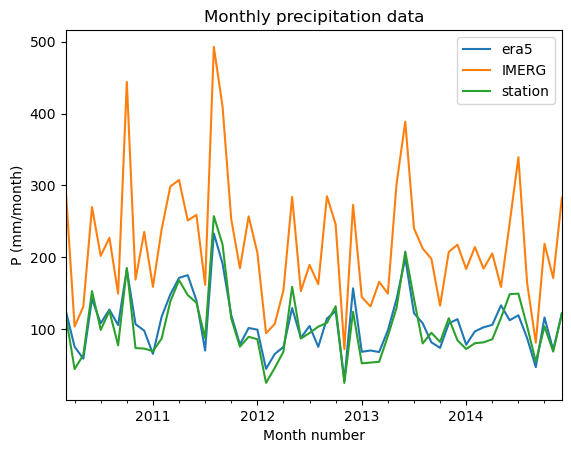

In [11]:
fig, ax = plt.subplots(1)
df_p.plot(ax=ax)
ax.set_title("Monthly precipitation data") 
ax.set_ylabel("P (mm/month)")
ax.set_xlabel("Month number");

In [12]:
# Compute monthly mean mP and variance vP of precipitation
df_p["mp"] = df_p.apply(lambda x: np.mean([x[f"{col}"] for col in x.index]),axis=1)
df_p["vp"] = df_p.apply(lambda x: (np.sum([(x[f"{col}"] - x.mp)**2 for col in x.index]))/(len(x.index)-1), axis=1)
df_p["sp"] = df_p.apply(lambda x: np.sqrt(x.vp) ,axis=1)

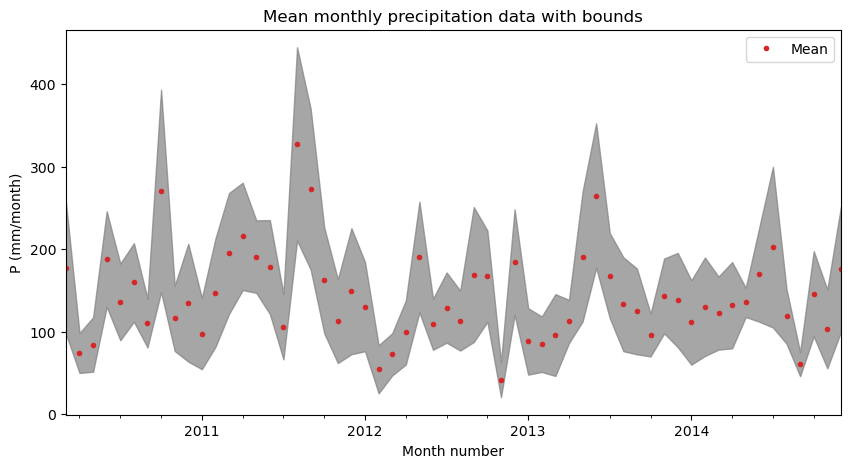

In [13]:
# Plot monthly mean and uncertainty interval (+-sigma) of precipitation.
# The plt.fill_between() function is useful for plotting an uncertainty interval.
fig, ax = plt.subplots(1,figsize=(10,5))
df_p[['mp']].plot(ax=ax,lw=0,color="C3",marker=".")
ax.fill_between(df_p.index,(df_p["mp"]+df_p["sp"]).values,(df_p["mp"]-df_p["sp"]).values,color="grey",alpha=0.7)

ax.set_title("Mean monthly precipitation data with bounds") 
ax.set_ylabel("P (mm/month)")
ax.set_xlabel("Month number")
ax.legend(["Mean"])

## E 
Load in EP from data collected already

In [14]:
ERA5_E = df_all_data[["Pev"]].rename(columns={"Pev":"Era5"}).resample('m').sum()

In [15]:
MODIS = pd.read_parquet(f"{data_folder}\\EP\\MODIS.parquet").dropna()
MODIS["PET"] = MODIS["PET"] * 0.1

"kg/m^2/8day"  -> mm: scale factor 0.1

In [16]:
MODIS_monthly = MODIS.resample('m').sum()
MODIS_monthly.rename(columns={"PET":"MODIS"},inplace=True)

In [17]:
GLEAM = pd.read_parquet(f"{data_folder}\\EP\\GLEAM.parquet").loc["2010":"2015"].rename(columns={"Pe":"GLEAM"})

In [18]:
df_e = pd.concat([ERA5_E,MODIS_monthly, GLEAM],axis=1).loc["2010-03":"2014"]
df_e.head(4)

,Era5,MODIS,GLEAM
2010-03-31,12.034393,76.1,46.713825
2010-04-30,22.913858,102.2,73.356728
2010-05-31,26.653820,191.2,100.432350
2010-06-30,30.533077,216.8,100.625893


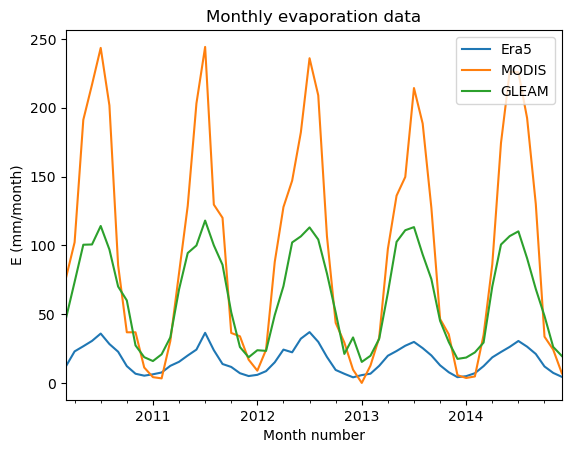

In [19]:
fig, ax = plt.subplots(1)
df_e.plot(ax=ax)
ax.set_title("Monthly evaporation data") 
ax.set_ylabel("E (mm/month)")
ax.set_xlabel("Month number");

In [20]:
# Compute monthly mean mE and variance vE of evaporation
df_e["me"] = df_e.apply(lambda x: np.mean([x[f"{col}"] for col in x.index]),axis=1)
df_e["ve"] = df_e.apply(lambda x: (np.sum([(x[f"{col}"] - x.me)**2 for col in x.index]))/(len(x.index)-1), axis=1)
df_e["se"] = df_e.apply(lambda x: np.sqrt(x.ve),axis=1)

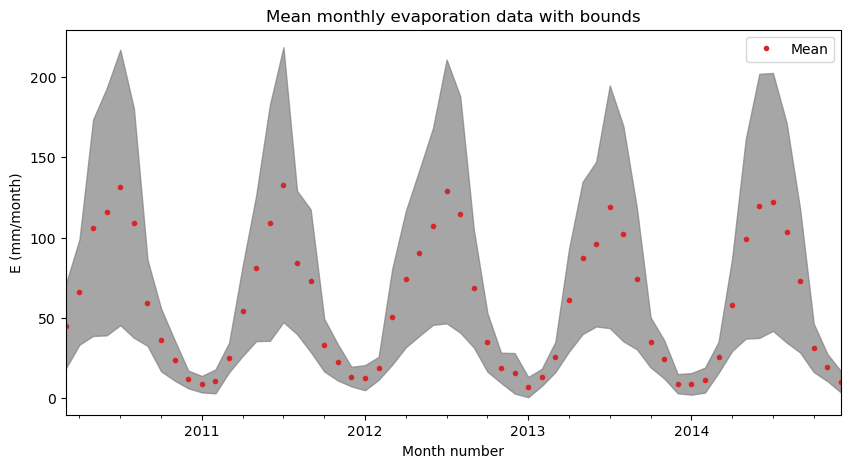

In [21]:
# Plot monthly mean and uncertainty interval (+-sigma) of evaporation
fig, ax = plt.subplots(1,figsize=(10,5))
df_e[['me']].plot(ax=ax,lw=0,color="C3",marker=".")
ax.fill_between(df_e.index,(df_e["me"]+df_e["se"]).values,(df_e["me"]-df_e["se"]).values,color="grey",alpha=0.7)

ax.set_title("Mean monthly evaporation data with bounds") 
ax.set_ylabel("E (mm/month)")
ax.set_xlabel("Month number")
ax.legend(["Mean"])

## Q 

Load station data already prepared

In [22]:
df_q = df_all_data[["Q"]].resample("m").sum().loc["2010-03":"2014"]
# Compute monthly mean mQ and variance vQ of river discharge
df_q["mq"] = df_q.apply(lambda x: np.mean([x[f"{col}"] for col in x.index]),axis=1)
df_q["vq"] = df_q.apply(lambda x: 0.1 * x.mq, axis=1)
df_q["sq"] = df_q.apply(lambda x: np.sqrt(x.vq),axis=1)

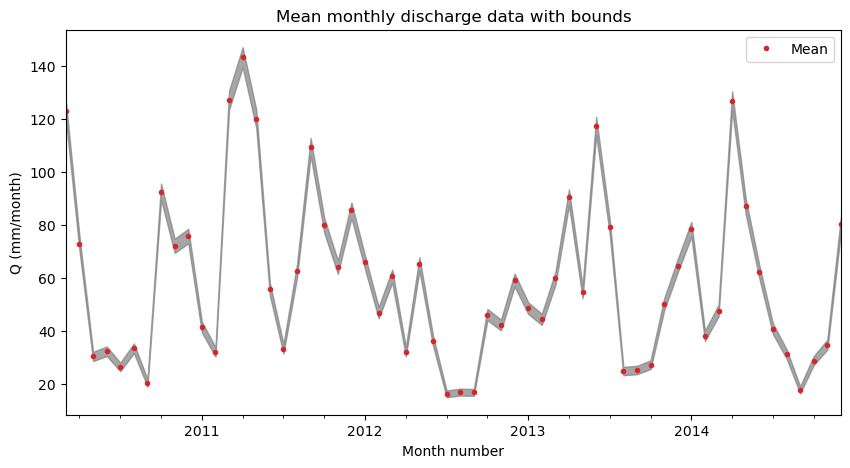

In [23]:
# Plot monthly mean and uncertainty interval (+-sigma) of river discharge
# Plot monthly mean and uncertainty interval (+-sigma) of evaporation
fig, ax = plt.subplots(1,figsize=(10,5))
df_q[['mq']].plot(ax=ax,lw=0,color="C3",marker=".")
ax.fill_between(df_q.index,(df_q["mq"]+df_q["sq"]).values,(df_q["mq"]-df_q["sq"]).values,color="grey",alpha=0.7)

ax.set_title("Mean monthly discharge data with bounds") 
ax.set_ylabel("Q (mm/month)")
ax.set_xlabel("Month number")
ax.legend(["Mean"])

## S 

In [48]:
df_GRACE = pd.read_parquet(f"{data_folder}\\Grace\\GRACE.parquet").loc["2010-03":"2014"]
df_GRACE_error = pd.read_parquet(f"{data_folder}\\GRace\\GRACE_error.parquet").loc["2010-03":"2014-12"]

In [49]:
df_s_in = pd.concat([df_GRACE,df_GRACE_error],axis=1).resample("m").mean()

In [50]:
wanted_index = df_q.apply(lambda x: f'{x.name.year}-{x.name.month}', axis=1).copy()

In [51]:
curent_index = df_s_in.apply(lambda x: f'{x.name.year}-{x.name.month}', axis=1)

In [52]:
df_index = pd.DataFrame(wanted_index).reset_index().set_index(0).rename(columns={"index":"fulldate"})

In [53]:
df_missing = df_index.loc[list(set(wanted_index.values).difference(set(curent_index.values)))].sort_values("fulldate").set_index("fulldate")

In [54]:
df_missing.head()

""
fulldate
2014-11-30
2014-12-31


In [55]:
df_missing['graceJPL'] = 0
df_missing['graceJPLerror'] = 10**9

In [56]:
df_s = pd.concat([df_s_in,df_missing[['graceJPL','graceJPLerror']]])
df_s["graceJPL"]  = df_s.apply(lambda x: 0 if np.isnan(x.graceJPL) else x.graceJPL, axis=1)
df_s["graceJPLerror"]  = df_s.apply(lambda x: 10**9 if np.isnan(x.graceJPLerror) else x.graceJPLerror, axis=1) 

In [57]:
# Compute monthly mean mS and variance vS of water storage
df_s["ms"]  = df_s.apply(lambda x: x.graceJPL if not np.isnan(x.graceJPL) else 0, axis=1) # 0  
df_s["ss"]  = df_s.apply(lambda x: x.graceJPLerror if x.graceJPLerror > -9999 else np.nan, axis=1) #10**9 if np.isnan(x.graceJPLerror) else 
df_s["vs"]  = df_s.apply(lambda x: x.graceJPLerror**2 if x.graceJPLerror > -9999 else 10**9, axis=1) #10**9 if np.isnan(x.graceJPLerror) else 

(-25.0, 20.0)

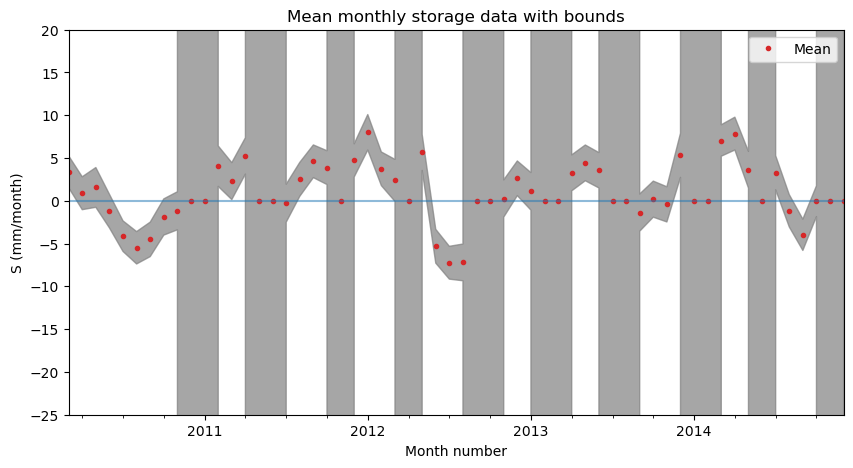

In [69]:
# Plot monthly mean and uncertainty interval (+-sigma) of water storage
fig, ax = plt.subplots(1,figsize=(10,5))
df_s[['ms']].plot(ax=ax,lw=0,color="C3",marker=".")
ax.fill_between(df_s.index,(df_s["ms"]+np.sqrt(df_s["vs"])).values,(df_s["ms"]-np.sqrt(df_s["vs"]).values),color="grey",alpha=0.7)

ax.axhline(0,alpha=0.5)
ax.set_title("Mean monthly storage data with bounds") 
ax.set_ylabel("S (mm/month)")
ax.set_xlabel("Month number")
ax.legend(["Mean"])
ax.set_ylim([-25,20])

### Generally large amount of uncretainty in the evaporation data which we aim to fix

Use function written in ex 2.6 to solve this issue

In [59]:
def gaussian_product(m1, v1, m2, v2):
    w1 = v2 / (v1 + v2)
    w2 = v1 / (v1 + v2)
    m = w1 * m1 + w2 * m2
    v = w1 * v1 
    # print(v, w2*v2)
    if not np.isclose(v, w2 * v2):
        print(f"Issue with V2, should be same {v}, {w2 * v2}")
        raise AssertionError
    return m, v

In [60]:
def close_water_balance(mP, vP, mE, vE, mQ, vQ, mS, vS):
    # Specify prior mean and variance for initial storage S0 (first month)
    mS0 = 0
    vS0 = 200 * 200#large variance to indicate large uncertainty
    print([len(mP), len(vP),len(mE), len(vE), len(mQ), len(vQ), len(mS), len(vS)])
    # Initialize posteriors
    # We compute these in forward loop (filtering posteriors) and then update them in backward loop (smoothing posteriors)
    nt = len(mP)#number of months in time-series
    mPostP = np.zeros(nt)#posterior mean of precipitation in each month
    vPostP = np.zeros(nt)#posterior variance of precipitation in each month
    mPostE = np.zeros(nt)#etc...
    vPostE = np.zeros(nt)
    mPostQ = np.zeros(nt)
    vPostQ = np.zeros(nt)
    mPostS = np.zeros(nt)
    vPostS = np.zeros(nt)
    
    # Forward loop (filtering)
    for t in range(nt):
        #####################################
        # Step 1: predict - compute forward distribution to S
        # YOUR CODE HERE
        if t != 0:
            mS0, vS0 = mPostS[t-1], vPostS[t-1]
            
        mS_1  =  mP[t] + mS0 - mE[t] - mQ[t]
        vS_1  =  vP[t] + vS0 + vE[t] + vQ[t]
        
        #####################################
        # Step 2: update - compute filtering posterior of S
        # YOUR CODE HERE
        
        mPostS[t], vPostS[t] = gaussian_product(mS_1, vS_1, mS[t], vS[t])
    # Backward loop (smoothing)
    mToS, vToS = 0.0, 1e+9#represents backward distribution to S - initialize to wide Gaussian for last month
    for t in reversed(range(nt)):
        #####################################
        # Step 1: smoothing posterior of S
        # YOUR CODE HERE
        
        mPostS[t], vPostS[t] = gaussian_product(mPostS[t], vPostS[t], mToS, vToS)
        
        #####################################
        # Step 2: posteriors of P, E, and Q
        # YOUR CODE HERE
                                        ### backwards S
        mBackS, vBackS = gaussian_product(mToS, vToS, mS[t], vS[t])
        
        if t != 0:
            mS0, vS0 = mPostS[t-1], vPostS[t-1]
        else: 
            mS0, vS0 = 0, 200*200
        
        # Q = P - S + S0 - E
        mQ_1  =  mP[t] - mBackS + mS0 - mE[t]
        vQ_1  =  vP[t] + vBackS + vS0 + vE[t]
        
        mPostQ[t], vPostQ[t] = gaussian_product(mQ[t],vQ[t], mQ_1, vQ_1)
        
        # P  = S - S0 + E + Q
        mP_1  =  + mBackS - mS0 + mE[t] + mQ[t]
        vP_1  =  + vBackS + vS0 + vE[t] + vQ[t]
        
        mPostP[t], vPostP[t] = gaussian_product(mP[t],vP[t], mP_1, vP_1)
        
        # E  = P + S0 - Q -S 
        mE_1  =  mP[t] - mBackS + mS0  - mQ[t]
        vE_1  =  vP[t] + vBackS + vS0  + vQ[t]
    
        mPostE[t], vPostE[t] = gaussian_product(mE[t],vE[t], mE_1, vE_1)
        
        #####################################
        # Step 3: backward distribution to S0
        # YOUR CODE HERE
        mToS = mBackS - mP[t] + mE[t] + mQ[t]
        vToS = vBackS + vP[t] + vE[t] + vQ[t]
    # After backward loop: compute posterior mean and variance of S0 (initial storage first month)
    # YOUR CODE HERE
    mPostS0, vPostS0 = gaussian_product(mToS, vToS, mS0, vS0)
    
    # Return final water balance estimates (posterior means and variances of monthly estimates)
    return mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0

In [61]:
vals = close_water_balance(df_p["mp"].values, df_p["vp"].values, df_e["me"].values, df_e["ve"].values, df_q["mq"].values, df_q["vq"].values, df_s["ms"].values, df_s["vs"].values)
mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0 = vals

[58, 58, 58, 58, 58, 58, 58, 58]


In [62]:
df_p["mPostP"] = mPostP
df_p["vPostP"] = vPostP
df_e["mPostE"] = mPostE
df_e["vPostE"] = vPostE
df_q["mPostQ"] = mPostQ
df_q["vPostQ"] = vPostQ
df_s["mPostS"] = mPostS
df_s["vPostS"] = vPostS

Text(0.5, 1.0, 'Error in the water balance')

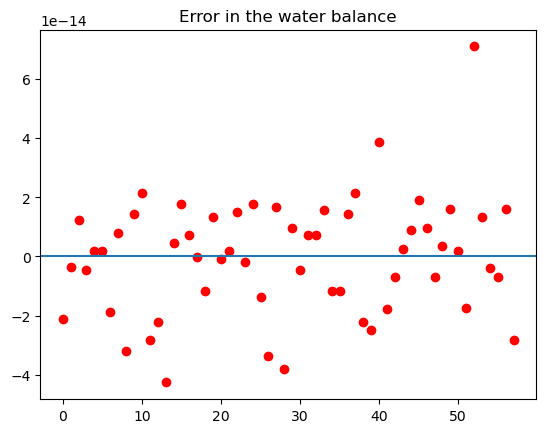

In [63]:
water_balance = np.zeros(len(mPostP))
storage_final = np.zeros(len(mPostP))

for t in range(len(mPostP)):
    if t == 0:
        S0 = mPostS0
    else:
        S0 = mPostS[t-1]
    water_balance[t] = mPostS[t] - mPostP[t]  + mPostE[t] + mPostQ[t] - S0
    storage_final[t] = mPostP[t]  - mPostE[t] - mPostQ[t] + S0
plt.plot(water_balance,"ro")
plt.axhline(0)
plt.title("Error in the water balance")

Text(0.5, 0, 'Month number')

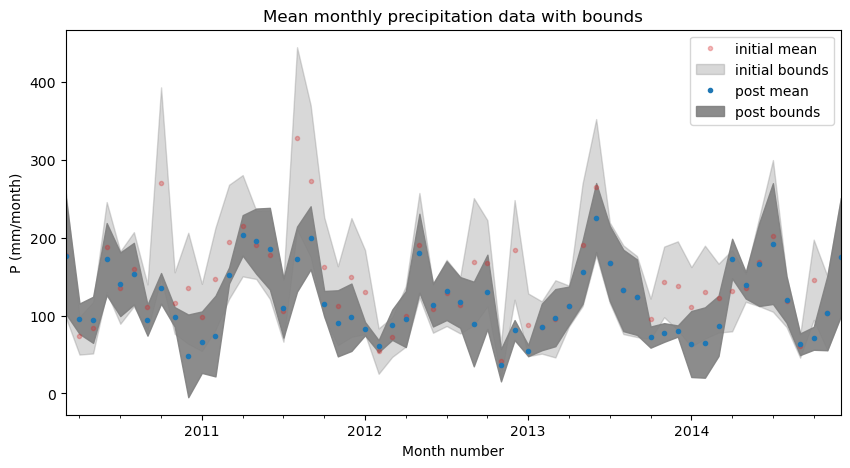

In [64]:
# The plt.fill_between() function is useful for plotting an uncertainty interval.
fig, ax = plt.subplots(1,figsize=(10,5))
df_p['mp'].plot(ax=ax,lw=0,color="C3",marker=".", alpha=0.3,label="initial mean")
ax.fill_between(df_p.index,(df_p["mp"]+df_p["sp"]).values,(df_p["mp"]-df_p["sp"]).values,color="grey",alpha=0.3, label="initial bounds")

df_p['mPostP'].plot(ax=ax,lw=0,color="C0",marker=".",label="post mean")
ax.fill_between(df_p.index,(df_p["mPostP"]+np.sqrt(df_p["vPostP"]).values),(df_p["mPostP"]-np.sqrt(df_p["vPostP"]).values),color="grey",alpha=0.9,label="post bounds")

ax.legend()
ax.set_title("Mean monthly precipitation data with bounds") 
ax.set_ylabel("P (mm/month)")
ax.set_xlabel("Month number")

Text(0.5, 0, 'Month number')

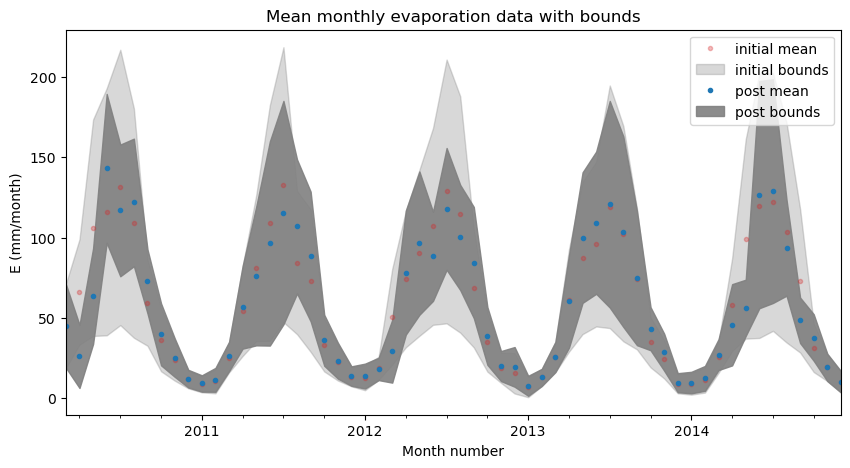

In [65]:
# The plt.fill_between() function is useful for plotting an uncertainty interval.
fig, ax = plt.subplots(1,figsize=(10,5))
df_e['me'].plot(ax=ax,lw=0,color="C3",marker=".", alpha=0.3,label="initial mean")
ax.fill_between(df_e.index,(df_e["me"]+df_e["se"]).values,(df_e["me"]-df_e["se"]).values,color="grey",alpha=0.3, label="initial bounds")

df_e['mPostE'].plot(ax=ax,lw=0,color="C0",marker=".",label="post mean")
ax.fill_between(df_e.index,(df_e["mPostE"]+np.sqrt(df_e["vPostE"]).values),(df_e["mPostE"]-np.sqrt(df_e["vPostE"]).values),color="grey",alpha=0.9,label="post bounds")
ax.legend()

ax.set_title("Mean monthly evaporation data with bounds") 
ax.set_ylabel("E (mm/month)")
ax.set_xlabel("Month number")

(-25.0, 20.0)

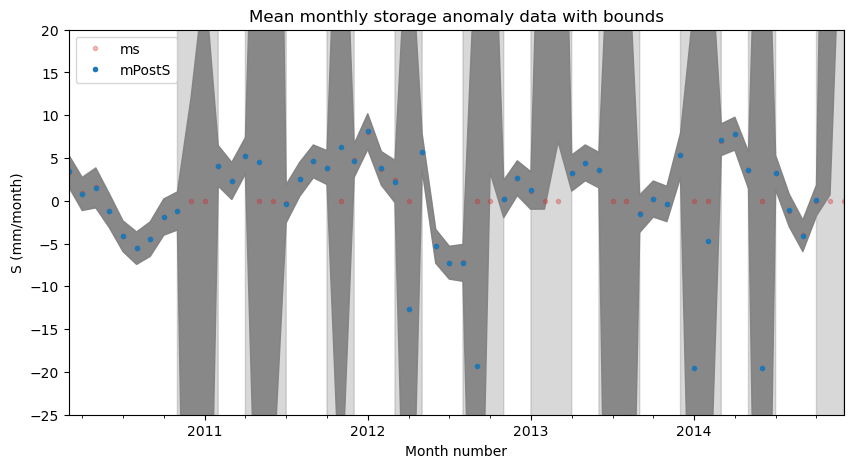

In [71]:
# The plt.fill_between() function is useful for plotting an uncertainty interval.
fig, ax = plt.subplots(1,figsize=(10,5))
df_s[['ms']].plot(ax=ax,lw=0,color="C3",marker=".", alpha=0.3,label="initial mean")
ax.fill_between(df_s.index,(df_s["ms"]+np.sqrt(df_s["vs"]).values),(df_s["ms"]-np.sqrt(df_s["vs"]).values),color="grey",alpha=0.3, label="initial bounds")

df_s[['mPostS']].plot(ax=ax,lw=0,color="C0",marker=".",label="post mean")
ax.fill_between(df_s.index,(df_s["mPostS"]+np.sqrt(df_s["vPostS"]).values),(df_s["mPostS"]-np.sqrt(df_s["vPostS"]).values),color="grey",alpha=0.9,label="post bounds")

ax.set_title("Mean monthly storage anomaly data with bounds") 
ax.set_ylabel("S (mm/month)")
ax.set_xlabel("Month number")
ax.set_ylim([-25,20])

Text(0.5, 0, 'Month number')

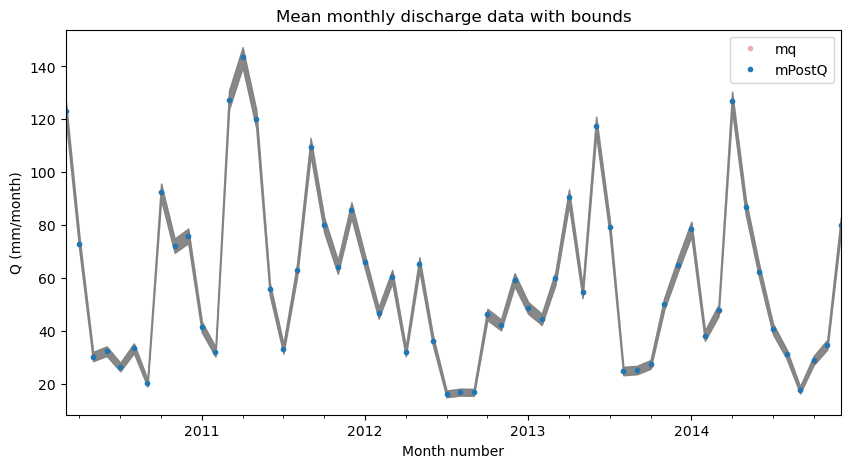

In [72]:
# The plt.fill_between() function is useful for plotting an uncertainty interval.
fig, ax = plt.subplots(1,figsize=(10,5))
df_q[['mq']].plot(ax=ax,lw=0,color="C3",marker=".", alpha=0.3,label="initial mean")
ax.fill_between(df_q.index,(df_q["mq"]+df_q["sq"]).values,(df_q["mq"]-df_q["sq"]).values,color="grey",alpha=0.3, label="initial bounds")

df_q[['mPostQ']].plot(ax=ax,lw=0,color="C0",marker=".",label="post mean")
ax.fill_between(df_q.index,(df_q["mPostQ"]+np.sqrt(df_q["vPostQ"]).values),(df_q["mPostQ"]-np.sqrt(df_q["vPostQ"]).values),color="grey",alpha=0.9,label="post bounds")

ax.set_title("Mean monthly discharge data with bounds") 
ax.set_ylabel("Q (mm/month)")
ax.set_xlabel("Month number")

# compare E to the mean monthly to the current 

Text(0.5, 0, 'Month number')

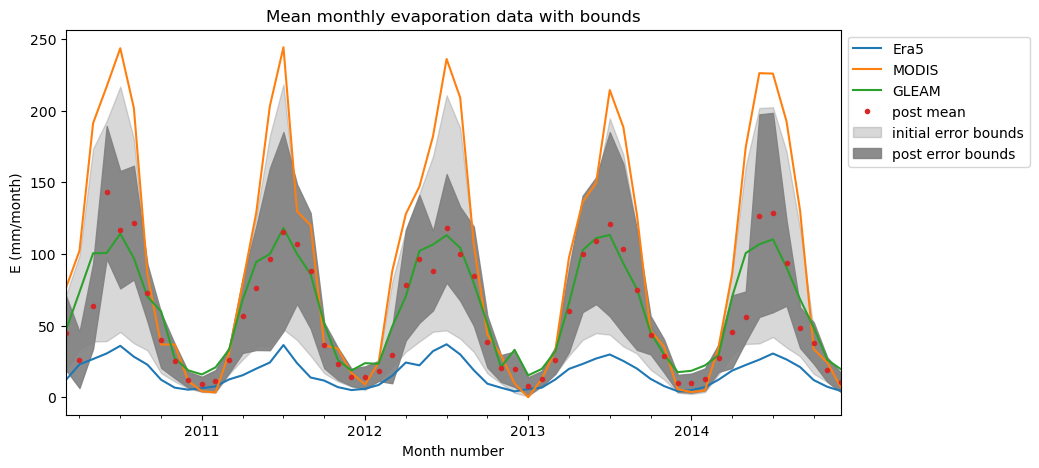

In [66]:
# The plt.fill_between() function is useful for plotting an uncertainty interval.
fig, ax = plt.subplots(1,figsize=(10,5))
df_e[["Era5","MODIS","GLEAM"]].plot(ax=ax)
df_e['mPostE'].plot(ax=ax,lw=0,color="C3",marker=".",label="post mean")
ax.fill_between(df_e.index,(df_e["me"]+df_e["se"]).values,(df_e["me"]-df_e["se"]).values,color="grey",alpha=0.3, label="initial error bounds")
ax.fill_between(df_e.index,(df_e["mPostE"]+np.sqrt(df_e["vPostE"]).values),(df_e["mPostE"]-np.sqrt(df_e["vPostE"]).values),color="grey",alpha=0.9,label="post error bounds")

ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Mean monthly evaporation data with bounds") 
ax.set_ylabel("E (mm/month)")
ax.set_xlabel("Month number")

### We see gleam is a much better fit for our data